#### Исходные данные

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import prop
from pandas import DataFrame
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import ode, simps
import math
import random

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Perараметры текста
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
#вспомогательные гд функции
tau = lambda lmbd, k: 1 - (k - 1)/(k + 1)*lmbd**2
pi = lambda lmbd, k: (1 - (k - 1)/(k + 1)*lmbd**2) ** (k / (k - 1))
eps = lambda lmbd, k: pi(lmbd,k) / tau(lmbd,k)
q = lambda lmbd, k:  ((k + 1) / 2)**(1 / (k - 1)) * lmbd * eps(lmbd, k)
nu = lambda lmbd, k: 1 / q(lmbd,k)
f = lambda lmbd, k: (lmbd**2 + 1) * (1 - (k - 1) / (k + 1) * lmbd**2) ** (1 / (k - 1))
A = lambda k: np.sqrt(k * ((2 / (k + 1))**((k + 1) / (k - 1))))

In [3]:
def results_for_one_m(m):
        n = 1
        ki = 1
        while m > ki:
            n += 3 * (m - ki)
            ki += 2

        D_nar = (D_km - 2e-3) / m
        D_vn = D_nar - 2 * e_0
        L_zar = S_g / (np.pi * n * (D_nar + D_vn))
        kappa_vn = 4 * L_zar / D_vn
        kappa_nar = 4 * n * D_nar * L_zar / (D_km**2 - n * D_nar ** 2)
        eps_s = (D_nar ** 2 - D_vn ** 2) / D_km ** 2 * n
        Sh = 4 * F_kr / (np.pi * D_km**2 * (1 - eps_s))

        result = {
            'm': m,
            'n': n,
            'D_nar': np.round(D_nar*1e3,1),
            'D_vn': np.round(D_vn*1e3,1),
            'L_zar': np.round(L_zar*1e3),
            'kappa_vn': np.round(kappa_vn,2),
            'kappa_nar': np.round(kappa_nar,2),
            'eps_s': np.round(eps_s,3),
            'Sh': np.round(Sh,3),
            'pass': []
        }

        if D_vn <= 1.5e-3:
            result['pass'].append('D_вн')
        if L_zar > L_max - L1 - L2 - L3:
            result['pass'].append(f'L_з на {(L_zar - (L_max - L1 - L2 - L3))*1e3:.1f} мм')
        if kappa_vn > kappa_pred:
            result['pass'].append('к_вн')
        if kappa_nar > kappa_pred:
            result['pass'].append('к_нар')
        if eps_s <= 0.5:
            result['pass'].append('eps_s')
        if Sh >= 0.75:
            result['pass'].append('Sh')

        return result

In [4]:
# Исходные данные
D_sn = 0.21    # калибр снаряда

# скорость полета во время коррекции, м/с
V_sn_kor_min = 210
V_sn_kor_max = 260
# угловая скорость снаряда, об/с
nu_sn_min = 5
nu_sn_max = 8
I_kor = 160     # требуемый импульс коррекции
fi2_tel = np.deg2rad(120) # телесный угол коррекции
n_du = 18       # 18
m_du_max = 0.35 # максимальная масса одного ИДК
# кол-во коррекций: 6 (по 3 ДУ),   12 (6 по 2 ДУ + 6 по 1 ДУ),   18 (по 1 ДУ)
# угол наклона сопла: 25 градусов
# угол между осями ДУ: 60 градусов
T_nom = 273.15 + 18
T_min = T_nom - 60
T_max = T_nom + 60

mu_c = 0.95
kappa_pred = 180
#L_treb = 55e-3

t_v = 1e-3  # = delta_t время выхода двигателя на режим
#У Аркаши было 1e-3 вместо 4е-3

#Не использовалось
m_sn = 93       # масса снаряда

#### 0. Комплексы варьирования

In [20]:
def calculate(var_dict):
    h = 4e-3

    D_du = var_dict['Диаметр ИДК']
    # максимальная длина ДУ
    L_max = (D_sn / 2 - np.sqrt(3) / 2 * D_du - 2 * h) / np.cos(np.deg2rad(25))
    #print(f'L_max = {L_max*1e3:.1f}')
    L_max = math.ceil(L_max * 1000) / 1000

    p1_max = var_dict['Максимальное давление в камере']
    # толщина стенки при максимальном давлении
    delta_st = np.round(1.3 * p1_max * D_du / (2 * 1000e6),4)
    #print(f'Толщина стенки = {delta_st*1e3:.1f}')
    D_km = np.round(D_du - 2 * delta_st,4)
    #print(f'Внутренний диаметр КС = {D_km*1e3:.1f}')

    # Определение времени работы ИДК
    t_d_min = 1 / nu_sn_max * fi2_tel / (2 * np.pi)
    t_d_max = 1 / nu_sn_min * fi2_tel / (2 * np.pi)
    #print(f'Время коррекции {t_d_min:.3f} ... {t_d_max:.3f} с')

    # Окончательное время 
    t_d = 0.042 
    # Коэффициент заполнения индикаторной кривой
    # ksi_max = interp1d(np.linspace(0.01,0.07,7),[0.5,0.55,0.65,0.75,0.79,0.8,0.8])
    # ksi_min = interp1d(np.linspace(0.01,0.07,7),[0.5,0.52,0.59,0.68,0.71,0.72,0.72])
    # # ksi = np.mean([ksi_min(t_d),ksi_max(t_d)])
    # ksi = ksi_max(t_d) - 0.01
    ksi = var_dict['Коэффициент заполнения индикаторной кривой ИДК']
    #print(f'ksi = {ksi:.3f}')

    t_g = t_d / 4 * (5 * ksi - 1) - 3/8 * t_v   # Время горения заряда топлива (первое приближение)
    t_g = math.ceil(t_g * 1000) / 1000
    t_p = t_d - t_v - t_g                       # Время последействия
    #print(f'Время горения заряда топлива: {t_g} c\nВремя последействия: {t_p:.3f} c')    


    # Назначим в первом приближении коэффициент расширения сопла
    zeta = var_dict['Коэффициент расширения сопла']

    # теоретический коэффициент тяги
    K_tf = interp1d(np.linspace(1.4,2.6,7),[1.46,1.51,1.56,1.6,1.62,1.64,1.67])
    K_t = K_tf(zeta) + 0
    #print(f'Теоретический коэффициент тяги {K_t}')
    # потери
    fi1 = 0.95
    fi2 = 0.95
    # Действительный коэффициент тяги
    K_d = fi1 * fi2 * K_t
    #print(f'Действительный коэффициент тяги {K_d:.3f}')


    # Коэффициенты
    a = 340
    # print(V_sn_kor_min, '-', V_sn_kor_max)
    # print(V_sn_kor_min/a, '-', V_sn_kor_max/a)

    K1 = 0.92
    K2 = 0.95

    # необходимая тяга
    P_need_ = I_kor / (K1 * K2 * ksi * t_d)
    P_need = P_need_/np.cos(np.deg2rad(25))

    # print(f'Необходимая тяга без потерь на угол {P_need_:.2f}')
    # print(f'Необходимая тяга ИДК {P_need:.2f}')


    # посчитать тепловые потери

    propel = var_dict['Топливо']
    # Из уравнения Бори находим минимальное и номинальное давления по одному заданному
    def fun(x):
        p1N, p1_min = x[0], x[1]
        return [propel.u(p1_max,T_max) / p1_max - propel.F1(p1N/1e6) / p1N,
                propel.u(p1_max,T_max) / (p1_max * propel.F3(T_min)) - propel.F1(p1_min/1e6) / p1_min]

    find_p1N = lambda p1N: propel.u(p1_max,T_max) / p1_max - propel.F1(p1N/1e6) / p1N
    find_p1_min = lambda p1_min: propel.u(p1_max,T_max) / (p1_max * propel.F3(T_min)) - propel.F1(p1_min/1e6) / p1_min

    p1N, p1_min = fsolve(fun,[0.9 * p1_max, 0.6 * p1_max])

    # print(f'p1N = {p1N/1e6:.3f} МПа\np1_min = {p1_min/1e6:.3f} МПа')
    
    # Площадь критического сечения сопла
    F_kr = P_need / (K_d * p1_min)    # Заменено с p1N
    # print(f'Площадь критики {F_kr}')

    # диаметр критического сечения сопла
    D_kr = np.sqrt(4 * F_kr / np.pi)
    # print(f'Диаметр критики {D_kr}')

    fi_vx = var_dict['Угол наклона дозвуковой части']
    fi_c = var_dict['Угол наклона сверхзвуковой части']

    # Длины участков сопла
    L1 = np.round((D_km - D_kr) / (2 * np.tan(fi_vx)),3)
    L2 = 2e-3
    L3 = np.round(D_kr/(2*np.tan(fi_c)) * (zeta - 1),4)

    # print(f'Длины блоков сопла: {L1,L2,L3}\n',
    #     f'Общая длина сопла: {L1 + L2 + L3}\n',
    #     f'Макс допуст длина заряда {L_max - (L1 + L2 + L3)}')

    # Расчет газодинамических параметров в выходном сечении сопла
    find_lambda_a = lambda lmbd: q(lmbd,propel.k) - 1 / zeta ** 2

    lambda_a = fsolve(find_lambda_a,1.5)[0]
    c_kr = np.sqrt(2 * propel.k / (propel.k + 1) * propel.R * propel.T0)
    V_a = lambda_a * c_kr
    p_a = pi(lambda_a,propel.k) * p1N
    T_a = tau(lambda_a,propel.k) * propel.T0
    rho_a = p_a / (propel.R * T_a)

    # print(f'Безразм скорость потока {lambda_a:.3f}\n',
    #     f'Критическая скорость звука {c_kr:.3f}\n',
    #     f'Скорость {V_a:.3f}\n',
    #     f'Давление {p_a/1e6:.3f}\n',
    #     f'Температура {T_a:.3f}\n',
    #     f'Плотность {rho_a:.3f}')

    G_p = mu_c * A(propel.k) * F_kr * p1_min / np.sqrt(propel.R * propel.T0)
    omega_t = G_p * t_g
    e_0 = 2 * propel.u(p1_min,T_min) * t_g
    S_g = omega_t / (propel.rho * propel.u(p1_min,T_min) * t_g)

    def results_for_one_m(m):
        n = 1
        ki = 1
        while m > ki:
            n += 3 * (m - ki)
            ki += 2

        D_nar = (D_km - 2e-3) / m
        D_vn = D_nar - 2 * e_0
        L_zar = S_g / (np.pi * n * (D_nar + D_vn))
        kappa_vn = 4 * L_zar / D_vn
        kappa_nar = 4 * n * D_nar * L_zar / (D_km**2 - n * D_nar ** 2)
        eps_s = (D_nar ** 2 - D_vn ** 2) / D_km ** 2 * n
        Sh = 4 * F_kr / (np.pi * D_km**2 * (1 - eps_s))

        result = {
            'm': m,
            'n': n,
            'D_nar': np.round(D_nar*1e3,1),
            'D_vn': np.round(D_vn*1e3,1),
            'L_zar': np.round(L_zar*1e3),
            'kappa_vn': np.round(kappa_vn,2),
            'kappa_nar': np.round(kappa_nar,2),
            'eps_s': np.round(eps_s,3),
            'Sh': np.round(Sh,3),
            'pass': []
        }

        if D_vn <= 1.5e-3:
            result['pass'].append('D_вн')
        if L_zar > L_max - L1 - L2 - L3:
            result['pass'].append(f'L_з на {(L_zar - (L_max - L1 - L2 - L3))*1e3:.1f} мм')
        if kappa_vn > kappa_pred:
            result['pass'].append('к_вн')
        if kappa_nar > kappa_pred:
            result['pass'].append('к_нар')
        if eps_s <= 0.5:
            result['pass'].append('eps_s')
        if Sh >= 0.75:
            result['pass'].append('Sh')

        return result

    results = []
    for m in range(3,13,2):
        results.append(results_for_one_m(m))

    df_dict = {}
    for data in results:
        if len(df_dict[data['pass']]) == 0:
            df_dict[data['m']] = list(data.values())[1:]
    df = DataFrame(df_dict,index = ['n','D_н','D_вн','L_з','к_вн','к_нар','eps_s','Sh','не подходит по'])
    df.style.hide(axis='index')

    df.plot


In [21]:
D_du_min, D_du_max = 20, 70
p1_max_min, p1_max_max = 50e6, 200e6
ksi_min, ksi_max= 0.7 - 3.447/30.795/10, 0.7 + 19.088/30.795/10
zeta_min, zeta_max  = 1.4, 2.6 
propels = ['P-1', 'P-2', 'P-3', 'B-1', 'B-2', 'B-3', 'C-1']
fi_vx_min, fi_vx_max = 40, 80
fi_c_min, fi_c_max = 15, 30 

D_du = random.randrange(D_du_min, D_du_max)/1000                       # Диаметр ИДК
p1_max = random.randrange(p1_max_min, p1_max_max)                      # Максимальное давление в камере
ksi = random.randrange(round(ksi_min*1000), round(ksi_max*1000))/1000  # Коэффициент заполнения индикаторной кривой ИДК
zeta = random.randint(int(zeta_min*10), int(zeta_max*10))/10           # Коэффициент расширения сопла                                                      # Теоретический коэффициент тяги
propel = prop.get_propellant(propels[-2])                              # Марка топлива
fi_vx = np.deg2rad(random.randrange(fi_vx_min, fi_vx_max))             # Угол наклона дозвуковой части
fi_c = np.deg2rad(random.randrange(fi_c_min, fi_c_max))                # Угол наклона сверхзвуковой части

var_dict = {
    'Диаметр ИДК': D_du,
    'Максимальное давление в камере': p1_max,
    'Коэффициент заполнения индикаторной кривой ИДК': ksi,
    'Коэффициент расширения сопла': zeta,
    'Топливо': propel,
    'Угол наклона дозвуковой части': fi_vx,
    'Угол наклона сверхзвуковой части': fi_c
}
for key, value in var_dict.items():
    print(key, ':', value)


calculate(var_dict)

Диаметр ИДК : 0.046
Максимальное давление в камере : 111708720
Коэффициент заполнения индикаторной кривой ИДК : 0.697
Коэффициент расширения сопла : 2.1
Топливо : <prop.__Prop object at 0x00000227ED49C9A0>
Угол наклона дозвуковой части : 0.9075712110370514
Угол наклона сверхзвуковой части : 0.29670597283903605


C:\Users\i_Ber\AppData\Local\Temp\ipykernel_3300\1712053588.py:10: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  p1_max = random.randrange(p1_max_min, p1_max_max)                      # Максимальное давление в камере


TypeError: unhashable type: 'list'

In [13]:
itog = results[-4]
L_zar = itog['L_zar']/1e3
D_nar = itog['D_nar']/1e3
D_vn = itog['D_vn']/1e3
n_zar = itog['n']

NameError: name 'results' is not defined

In [ ]:
print(n_zar)

19


In [ ]:
sigma_t = 300
nu_t = 0.7

# тепловые потери
# F_oxl = 1.2 * np.pi * D_km * L_zar + n_zar * np.pi * L_zar * (D_vn + D_nar) + \
#         np.pi * n_zar / 2 * (D_nar**2 - D_vn**2)
# Q_zh = propel.k / (propel.k - 1) * propel.R * propel.T0

# def chi_teplf(p0):
#      chi_tepl1 = sigma_t * nu_t * F_oxl * p0 / (Q_zh * propel.R * G_p)
#      chi_tepl2 = propel.k / (propel.k - 1) * p0 / (propel.rho * Q_zh)
#      return 1 - chi_tepl1 - chi_tepl2
# print(chi_teplf(p1_max))

#### Расчет воспламенителя

In [ ]:
sigma_t = 300
v_t = 0.7

R_v = 314
Q_v = 3050e3
u_v = 0.05
k_v = 1.25
rho_v = 1700
e_v = 4e-3
m_v = 3
p_atm = 101325

t_vv = e_v / u_v
T_v = ((k_v - 1) / k_v) * (Q_v / R_v)
T_s = 500

W_0 = np.pi / 4 * (D_km**2) * L_zar - omega_t / propel.rho
F_oxl = 1.2 * np.pi * D_km * L_zar + n_zar * np.pi * L_zar * (D_vn + D_nar) + \
        np.pi * n_zar / 2 * (D_nar**2 - D_vn**2)

lambda_t = 0.23

def p_vsp(T0):
    return 1250 * propel.rho / sigma_t * propel.u(0.5e6, T0) * R_v * T_v * (T_s - T0) / (T_v - T_s)

p_vsp_50 = p_vsp(273.15 - 50)
#p_vsp_50 = 5e6
p_max = 1.1 * p_vsp_50
print(f'p_vsp-50 = {p_vsp_50/1e6:.3f}')

b2 = (((propel.k - 1) / W_0) * (v_t * sigma_t * F_oxl / propel.R)) + ((propel.k * A(propel.k) * F_kr / W_0) *\
     (np.sqrt(propel.R * propel.T0)))
S0_v = (p_max * b2 * ((m_v / (t_vv * b2)) ** (-m_v / (t_vv * b2 - m_v)))) / (((propel.k - 1) / W_0) * u_v * rho_v * Q_v)
b1 = ((propel.k-1) / W_0) * rho_v * S0_v * u_v * Q_v


def p_v(t):
    p = - ((b1 / ((m_v / t_vv) - b2)) * (np.exp(- m_v * t / t_vv))) + ((p_atm + (b1 / ((m_v / t_vv) - b2))) * (np.exp(- b2 * t)))
    return p

omega_v = e_v * rho_v * S0_v * ((1 - np.exp(- m_v)) / m_v)
print(f'omega_v = {(omega_v):.5f}')

p_vsp-50 = 0.129
omega_v = -0.00166


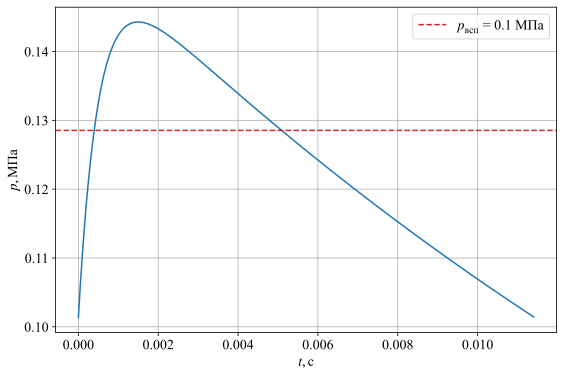

In [ ]:
t_vs = np.linspace(0,0.1,2000)
p_vs = np.array([p_v(t) for t in t_vs])

f = plt.figure(figsize=(9, 6))
plt.plot(t_vs[p_vs >= p_atm], p_vs[p_vs >= p_atm]/1e6)
plt.axhline(p_vsp_50/1e6, linestyle = '--', color = 'tab:red', label = '$\mathit{p}_{всп}$ = '+f'{p_vsp_50/1e6:.1f} МПа')

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('$\mathit{t}, с$')
plt.ylabel('$\mathit{p}, МПа$')
# plt.savefig('График pW0.svg', dpi=500, bbox_inches='tight')

plt.show()

In [ ]:
t_vs[p_vs >= p_vsp_50][0]*1e3

0.40020010005002504

#### ОЗВБ

In [ ]:
mu_c = 0.95
e_max = e_0
Q_t = propel.k / (propel.k - 1) * propel.R * propel.T0

def S_zar(e):
    return n_zar * (np.pi * (D_vn + 2 * e)*(L_zar - 2 * e) + np.pi * (D_nar - 2 * e) * (L_zar - 2 * e) + \
        2 * np.pi * 0.25 * (((D_nar - 2 * e) ** 2) - ((D_vn + 2 * e) ** 2)))

In [ ]:
def sys_int(t, Y, T0, p_vsp):

    p, W, omega_g, omega_vg, e_t = Y
    U = np.zeros(5)

    Hev_v = 1 if t <= t_v else 0
    Hev_p = 1 if p > p_vsp or abs(e_t) > 0 else 0
    Hev_e = 1 if 0 <= abs(e_t) <= e_max else 0

    u_g = propel.u(p,T0)
    S_g = S_zar(abs(e_t))

    #domega_v/dt
    U[3] = S0_v * np.exp(-m_v * t / t_v) * u_v * rho_v * Hev_v

    #dp/dt
    p1 = (propel.k - 1) * Q_v / (propel.rho * S_g * u_g) * U[3] + (propel.k - 1) * Q_t * Hev_e
    p2 = propel.k * (mu_c * A(propel.k) * F_kr * p / (propel.rho * S_g * u_g)) ** 2
    p3 = (propel.k - 1) * sigma_t * v_t * F_oxl * p / (propel.R * propel.rho * S_g * u_g)
    p4 = propel.k * p / (rho_v * propel.rho * S_g * u_g) * U[3]
    p5 = propel.k * p / propel.rho * Hev_e
    U[0] = (p1 - p2 - p3 - p4 - p5) * propel.rho * S_g * u_g / W

    #de/dt
    U[4] = u_g * Hev_p * Hev_e

    #domega_t/dt
    U[2] = S_g * propel.rho * U[4]

    #dW/dt
    U[1] = 1 / propel.rho * U[2] + 1 / rho_v * U[3]

    return U

def res_int(T0):

    stop = lambda p: p * pi(1,propel.k) <= p_atm
    # stop = lambda p: p <= p_atm

    Y_0 = [0, p_atm, W_0, 0, 0, 0]

    result = dict()
    keys = ['t','p','W','omega_g','omega_gv','e_t']
    for key, val in zip(keys,Y_0):
        result[key] = np.array([val])

    r = ode(sys_int).set_integrator('vode', method = 'adams')     #'vode', method = 'adams'
    r.set_initial_value(Y_0[1:])
    r.set_f_params(T0, p_vsp(T0))

    while r.successful() and (not stop(result['p'][-1]) or result['t'][-1] < 0.005):
        dt = 5e-6
        result['t'] = np.append(result['t'], result['t'][-1] + dt)
        Y_tek = r.integrate(r.t+dt)
        for key, val in zip(keys[1:],Y_tek):
            if key != 'p':
                result[key] = np.append(result[key], val)
            else:
                result[key] = np.append(result[key], val * 1)

    return result

In [ ]:
res18 = res_int(T_nom)
res50 = res_int(T_max)
res_50 = res_int(T_min)

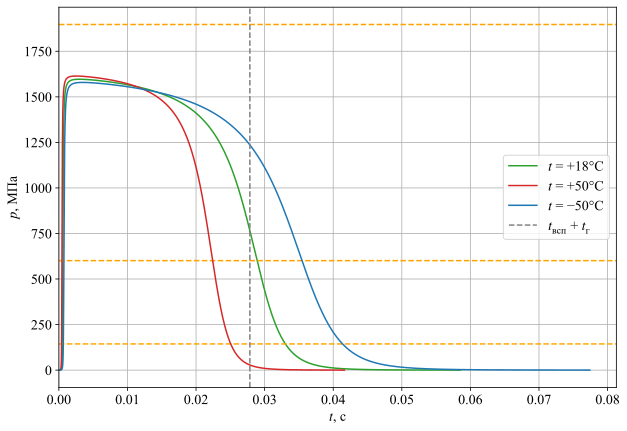

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(res18['t'],res18['p']/1e6, c = 'tab:green', label = '$\mathit{t}$ = +18°C')
plt.axhline(p1_max/1e6,ls = '--',c = 'orange')
plt.axhline(p1_min/1e6,ls = '--',c = 'orange')
plt.axhline(p1N/1e6,ls = '--',c = 'orange')
plt.plot(res50['t'],res50['p']/1e6, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
plt.plot(res_50['t'],res_50['p']/1e6, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
plt.axvline(t_g + 0.85e-3,ls = '--',c = 'grey', label = '$\mathit{t}_{всп}$ + $\mathit{t}_г$')

plt.xlim(0)
# plt.ylim(top = 18.5)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend()
plt.grid()
# plt.savefig('Инд p.svg', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
G_ts = lambda res, T_0: np.array([S_zar(abs(e_t)) * propel.rho * propel.u(p,T_0) for e_t, p in zip(res['e_t'],res['p'])])
Ps = lambda res, T_0: 1.365*np.array([G_t * V_a + np.pi * zeta * D_kr**2 / 4 * (p * 1.05 * pi(lambda_a,propel.k) - p_atm) for G_t, p in zip(G_ts(res,T_0),res['p'])])

I_sumf = lambda res, T_0: simps(Ps(res,T_0),res['t'])

# Импульсы
I_sumf(res_50,T_min), I_sumf(res18,T_nom), I_sumf(res_50,T_max), I_kor

(-51525.54133556599, -44130.76217427655, -79928.62539024207, 160)

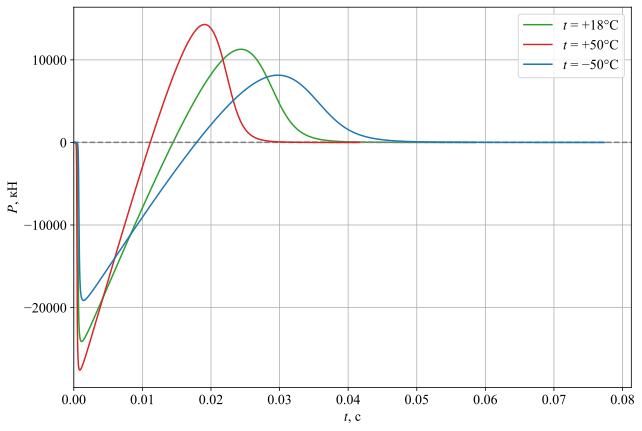

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(res18['t'],Ps(res18,273.15+18)/1e3, c = 'tab:green', label = '$\mathit{t}$ = +18°C')
plt.axhline(P_need/1e3,ls = '--',c = 'grey')
plt.plot(res50['t'],Ps(res50,273.15+50)/1e3, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
plt.plot(res_50['t'],Ps(res_50,273.15-50)/1e3, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')

plt.xlim(0)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{P}$, кН')
plt.legend()
plt.grid()
# plt.savefig('Инд Pp.svg', dpi=500, bbox_inches='tight')